In [4]:
import numpy as np
import cv2
import matplotlib.pyplot as plt


In [7]:
def video_to_matrix(video_path):
    cap = cv2.VideoCapture(video_path)
    frames = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        # Convert BGR to RGB
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame_rgb)
    cap.release()
    frames = np.array(frames)
    return frames

# Load video frames
video_path = r'C:\Users\varun kumar\Downloads\MDSC\Video_comp.mp4'  # Replace with your video file path
frames = video_to_matrix(video_path)
num_frames, height, width, channels = frames.shape
print(f"Loaded {num_frames} frames of size {height}x{width}")


Loaded 132 frames of size 720x1280


In [3]:
!pip install opencv-python

  Obtaining dependency information for opencv-python from https://files.pythonhosted.org/packages/ec/6c/fab8113424af5049f85717e8e527ca3773299a3c6b02506e66436e19874f/opencv_python-4.10.0.84-cp37-abi3-win_amd64.whl.metadata
   ---------------------------------------- 0.0/38.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/38.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/38.8 MB 653.6 kB/s eta 0:01:00
   ---------------------------------------- 0.1/38.8 MB 1.2 MB/s eta 0:00:33
   ---------------------------------------- 0.3/38.8 MB 1.8 MB/s eta 0:00:22
   ---------------------------------------- 0.3/38.8 MB 1.6 MB/s eta 0:00:25
    --------------------------------------- 0.6/38.8 MB 2.3 MB/s eta 0:00:17
    --------------------------------------- 0.8/38.8 MB 2.7 MB/s eta 0:00:14
    --------------------------------------- 1.0/38.8 MB 2.9 MB/s eta 0:00:14
   - -------------------------------------- 1.1/38.8 MB 2.8 MB/s eta 0:00:14
   - ---------------

In [8]:
def frames_to_2d_matrix(frames):
    num_frames, height, width, channels = frames.shape
    # Flatten each frame into a 1D vector
    frames_reshaped = frames.reshape(num_frames, -1)
    return frames_reshaped

# Reshape frames into 2D matrix
frames_matrix = frames_to_2d_matrix(frames)
print(f"Frames matrix shape: {frames_matrix.shape}")


Frames matrix shape: (132, 2764800)


In [9]:
# Perform SVD
U, S, Vt = np.linalg.svd(frames_matrix, full_matrices=False)
print(f"SVD completed: U-{U.shape}, S-{S.shape}, Vt-{Vt.shape}")


SVD completed: U-(132, 132), S-(132,), Vt-(132, 2764800)


In [11]:
def reconstruct_frames(U, S, Vt, k):
    U_k = U[:, :k]
    S_k = S[:k]
    Vt_k = Vt[:k, :]
    # Reconstruct the frames matrix
    frames_reconstructed = np.dot(U_k, np.dot(np.diag(S_k), Vt_k))
    return frames_reconstructed

def reconstruction_error(original_matrix, reconstructed_matrix):
    # Compute the Frobenius norm of the difference and normalize
    error = np.linalg.norm(original_matrix - reconstructed_matrix, 'fro') / np.linalg.norm(original_matrix, 'fro')
    return error

# Define the error threshold
threshold = 0.1  # Adjust the threshold as needed

# Initialize variables
min_k = None
errors = []

# Determine the range of k values to test
max_k = min(frames_matrix.shape)  # The maximum possible rank
k_values = range(1, max_k, 5)  # You can adjust the step size for finer control

# Find the minimum k where error <= threshold
for k in k_values:
    frames_reconstructed = reconstruct_frames(U, S, Vt, k)
    error = reconstruction_error(frames_matrix, frames_reconstructed)
    errors.append(error)
    print(f"k = {k}, Reconstruction Error = {error}")
    if error <= threshold:
        min_k = k
        break

if min_k is not None:
    print(f"Minimum k found: {min_k} with error = {error}")
else:
    print("No k found that satisfies the error threshold within the tested range.")


k = 1, Reconstruction Error = 0.21787510858243703
k = 6, Reconstruction Error = 0.10590572714302751
k = 11, Reconstruction Error = 0.08000264562344238
Minimum k found: 11 with error = 0.08000264562344238


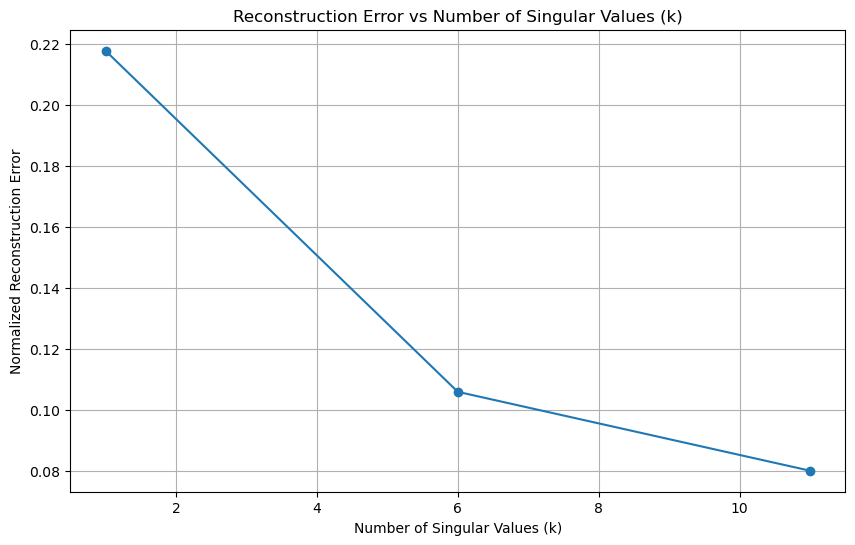

In [12]:
# Plot the reconstruction error vs k
plt.figure(figsize=(10, 6))
plt.plot(k_values[:len(errors)], errors, marker='o')
plt.title('Reconstruction Error vs Number of Singular Values (k)')
plt.xlabel('Number of Singular Values (k)')
plt.ylabel('Normalized Reconstruction Error')
plt.grid(True)
plt.show()


In [13]:
if min_k is not None:
    # Reconstruct frames matrix with min_k
    frames_reconstructed_matrix = reconstruct_frames(U, S, Vt, min_k)
    # Reshape back to original dimensions
    frames_reconstructed = frames_reconstructed_matrix.reshape((num_frames, height, width, channels))
    # Clip values to valid range and convert to uint8
    frames_reconstructed = np.clip(frames_reconstructed, 0, 255).astype('uint8')
else:
    # Handle the case where no suitable k was found
    # You might choose to use the maximum k tested
    min_k = k_values[-1]
    frames_reconstructed_matrix = reconstruct_frames(U, S, Vt, min_k)
    frames_reconstructed = frames_reconstructed_matrix.reshape((num_frames, height, width, channels))
    frames_reconstructed = np.clip(frames_reconstructed, 0, 255).astype('uint8')
    print(f"Using k = {min_k} for reconstruction due to threshold constraints.")


In [8]:
def save_video(frames, output_path, fps=20.0):
    height, width, channels = frames[0].shape
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Change codec as needed
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))
    for frame in frames:
        # Convert RGB back to BGR for OpenCV
        frame_bgr = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
        out.write(frame_bgr)
    out.release()
    print(f"Video saved to {output_path}")

# Save the reconstructed video
output_path = 'reconstructed_video.mp4'  # Specify your output file path
save_video(frames_reconstructed, output_path)


Video saved to reconstructed_video.mp4


In [9]:
def compression_percentage(original_shape, k):
    num_frames, total_pixels = original_shape
    # Number of elements in original video
    original_elements = num_frames * total_pixels

    # Number of elements in compressed video
    # U_k: num_frames * k
    # S_k: k
    # Vt_k: k * total_pixels
    compressed_elements = num_frames * k + k + k * total_pixels

    compression_ratio = (1 - (compressed_elements / original_elements)) * 100
    return compression_ratio

total_pixels = height * width * channels
original_shape = (num_frames, total_pixels)
compression_ratio = compression_percentage(original_shape, min_k)
print(f"Compression Percentage: {compression_ratio:.2f}%")


Compression Percentage: 91.67%
